In [1]:
from pyspark.sql import SparkSession

try:
  spark = SparkSession.builder.getOrCreate()
except:
  print("Already running.")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/19 01:44:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [37]:
df = spark.read.option("header",True).option("inferSchema", True).csv("../data/marvel/charcters_stats.csv")
df.createOrReplaceGlobalTempView("comic_characters_stats")

In [38]:
df = spark.sql("select * from global_temp.comic_characters_stats")
df.show()

+-----------------+---------+------------+--------+-----+----------+-----+------+-----+
|             Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|
+-----------------+---------+------------+--------+-----+----------+-----+------+-----+
|          3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|
|           A-Bomb|     good|          38|     100|   17|        80|   17|    64|  316|
|       Abe Sapien|     good|          88|      14|   35|        42|   35|    85|  299|
|         Abin Sur|     good|          50|      90|   53|        64|   84|    65|  406|
|      Abomination|      bad|          63|      80|   53|        90|   55|    95|  436|
|          Abraxas|      bad|          88|     100|   83|        99|  100|    56|  526|
|      Adam Monroe|     good|          63|      10|   12|       100|   71|    64|  320|
|     Adam Strange|     good|           1|       1|    1|         1|    0|     1|    5|
|        Agent  13|     good|   

In [43]:
df.dtypes

[('Name', 'string'),
 ('Alignment', 'string'),
 ('Intelligence', 'int'),
 ('Strength', 'int'),
 ('Speed', 'int'),
 ('Durability', 'int'),
 ('Power', 'int'),
 ('Combat', 'int'),
 ('Total', 'int')]

In [44]:
df.describe().show()

+-------+-------+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|   Name|Alignment|     Intelligence|          Strength|             Speed|        Durability|             Power|           Combat|             Total|
+-------+-------+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|    611|      608|              611|               611|               611|               611|               611|              611|               611|
|   mean|   null|     null|44.50245499181669|29.083469721767592|27.306055646481177| 41.83960720130933|40.312602291325696|43.20621931260229|226.25040916530278|
| stddev|   null|     null|32.92472154848242|32.610939104122245|25.760172830410838|36.543849284129806| 34.53991022424559|33.27032883710156|167.32403376210624|
|    min|3-D Man|      bad|                1| 

In [103]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----+---------+------------+--------+-----+----------+-----+------+-----+
|Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|
+----+---------+------------+--------+-----+----------+-----+------+-----+
|   0|        2|           0|       0|    0|         0|    0|     0|    0|
+----+---------+------------+--------+-----+----------+-----+------+-----+



In [90]:
spark.sql("select distinct Alignment from global_temp.comic_characters_stats").show()

+---------+
|Alignment|
+---------+
|     null|
|  neutral|
|      bad|
|     good|
+---------+



In [100]:
spark.sql("""
  select count(*) from global_temp.comic_characters_stats 
  where Total<=5
""").show()

+--------+
|count(1)|
+--------+
|     177|
+--------+



In [102]:
from pyspark.sql.functions import corr
correlations = df.select(
  corr("Intelligence", "Combat").alias("Intelligence"),
  corr("Strength", "Combat").alias("Strength"),
  corr("Speed", "Combat").alias("Speed"),
  corr("Durability", "Combat").alias("Durability"),
  corr("Power", "Combat").alias("Power"),
)
correlations.show()

+------------------+------------------+------------------+-------------------+------------------+
|      Intelligence|          Strength|             Speed|         Durability|             Power|
+------------------+------------------+------------------+-------------------+------------------+
|0.3157079885205103|0.2635094134152325|0.1474043448727191|0.24520298832626214|0.1247302718683961|
+------------------+------------------+------------------+-------------------+------------------+



In [46]:
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Alignment", outputCol="AlignmentIndex", handleInvalid="keep")
index = indexer.fit(df).transform(df)

In [49]:
index.write.format("parquet").mode("overwrite").save("../data/transform/indexed_comic_characters")

In [50]:
indexed = spark.read.format("parquet").load("../data/transform/indexed_comic_characters")

indexed.show()

+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+
|             Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|
+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+
|          3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|           0.0|
|           A-Bomb|     good|          38|     100|   17|        80|   17|    64|  316|           0.0|
|       Abe Sapien|     good|          88|      14|   35|        42|   35|    85|  299|           0.0|
|         Abin Sur|     good|          50|      90|   53|        64|   84|    65|  406|           0.0|
|      Abomination|      bad|          63|      80|   53|        90|   55|    95|  436|           1.0|
|          Abraxas|      bad|          88|     100|   83|        99|  100|    56|  526|           1.0|
|      Adam Monroe|     good|          63|      10|   12|       100|   71

In [51]:
from pyspark.sql.functions import corr
correlations = indexed.select(
  corr("Intelligence", "Combat").alias("Intelligence"),
  corr("Strength", "Combat").alias("Strength"),
  corr("Speed", "Combat").alias("Speed"),
  corr("Durability", "Combat").alias("Durability"),
  corr("Power", "Combat").alias("Power"),
  corr("AlignmentIndex", "Combat").alias("AlignmentIndex"),
)
correlations.show()

+------------------+------------------+------------------+------------------+------------------+-------------------+
|      Intelligence|          Strength|             Speed|        Durability|             Power|     AlignmentIndex|
+------------------+------------------+------------------+------------------+------------------+-------------------+
|0.7836794290778267|0.5750452024920397|0.5945683812384139|0.6795828692064926|0.6534522658023663|0.06599941707519337|
+------------------+------------------+------------------+------------------+------------------+-------------------+



In [52]:
indexed.describe().show()

+-------+-------+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|summary|   Name|Alignment|     Intelligence|          Strength|             Speed|        Durability|             Power|           Combat|             Total|     AlignmentIndex|
+-------+-------+---------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|  count|    611|      608|              611|               611|               611|               611|               611|              611|               611|                611|
|   mean|   null|     null|44.50245499181669|29.083469721767592|27.306055646481177| 41.83960720130933|40.312602291325696|43.20621931260229|226.25040916530278|0.32078559738134205|
| stddev|   null|     null|32.92472154848242|32.610939104122245|25.760172830410838|36.543849284129806| 34

In [53]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="AlignmentIndex", outputCol="AlignmentEncoded", handleInvalid="keep")
encoded = encoder.fit(indexed).transform(indexed)
encoded.show()

+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+----------------+
|             Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|AlignmentEncoded|
+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+----------------+
|          3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|           0.0|   (4,[0],[1.0])|
|           A-Bomb|     good|          38|     100|   17|        80|   17|    64|  316|           0.0|   (4,[0],[1.0])|
|       Abe Sapien|     good|          88|      14|   35|        42|   35|    85|  299|           0.0|   (4,[0],[1.0])|
|         Abin Sur|     good|          50|      90|   53|        64|   84|    65|  406|           0.0|   (4,[0],[1.0])|
|      Abomination|      bad|          63|      80|   53|        90|   55|    95|  436|           1.0|   (4,[1],[1.0])|
|          Abraxas|      bad|          8

In [54]:
from pyspark.sql.functions import isnull, when, count, col

encoded.select([count(when(isnull(c), c)).alias(c) for c in encoded.columns]).show()

+----+---------+------------+--------+-----+----------+-----+------+-----+--------------+----------------+
|Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|AlignmentEncoded|
+----+---------+------------+--------+-----+----------+-----+------+-----+--------------+----------------+
|   0|        3|           0|       0|    0|         0|    0|     0|    0|             0|               0|
+----+---------+------------+--------+-----+----------+-----+------+-----+--------------+----------------+



In [55]:
indexed.dtypes

[('Name', 'string'),
 ('Alignment', 'string'),
 ('Intelligence', 'int'),
 ('Strength', 'int'),
 ('Speed', 'int'),
 ('Durability', 'int'),
 ('Power', 'int'),
 ('Combat', 'int'),
 ('Total', 'int'),
 ('AlignmentIndex', 'double')]

In [56]:
from pyspark.sql.functions import col

ml_ready_df = indexed.withColumn("AlignmentIndex",col("AlignmentIndex").cast('integer')).drop('Name').drop('Alignment').drop('Total')
ml_ready_df.show()

+------------+--------+-----+----------+-----+------+--------------+
|Intelligence|Strength|Speed|Durability|Power|Combat|AlignmentIndex|
+------------+--------+-----+----------+-----+------+--------------+
|          50|      31|   43|        32|   25|    52|             0|
|          38|     100|   17|        80|   17|    64|             0|
|          88|      14|   35|        42|   35|    85|             0|
|          50|      90|   53|        64|   84|    65|             0|
|          63|      80|   53|        90|   55|    95|             1|
|          88|     100|   83|        99|  100|    56|             1|
|          63|      10|   12|       100|   71|    64|             0|
|           1|       1|    1|         1|    0|     1|             0|
|           1|       1|    1|         1|    0|     1|             0|
|          10|       8|   13|         5|    5|    20|             0|
|          75|      28|   38|        80|   72|    95|             0|
|          50|      85|  100|     

In [57]:
ml_ready_df.describe().show()

+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-------------------+
|summary|     Intelligence|          Strength|             Speed|        Durability|             Power|           Combat|     AlignmentIndex|
+-------+-----------------+------------------+------------------+------------------+------------------+-----------------+-------------------+
|  count|              611|               611|               611|               611|               611|              611|                611|
|   mean|44.50245499181669|29.083469721767592|27.306055646481177| 41.83960720130933|40.312602291325696|43.20621931260229|0.32078559738134205|
| stddev|32.92472154848242|32.610939104122245|25.760172830410838|36.543849284129806| 34.53991022424559|33.27032883710156|  0.532741168220379|
|    min|                1|                 1|                 1|                 1|                 0|                1|                  0|
|    m

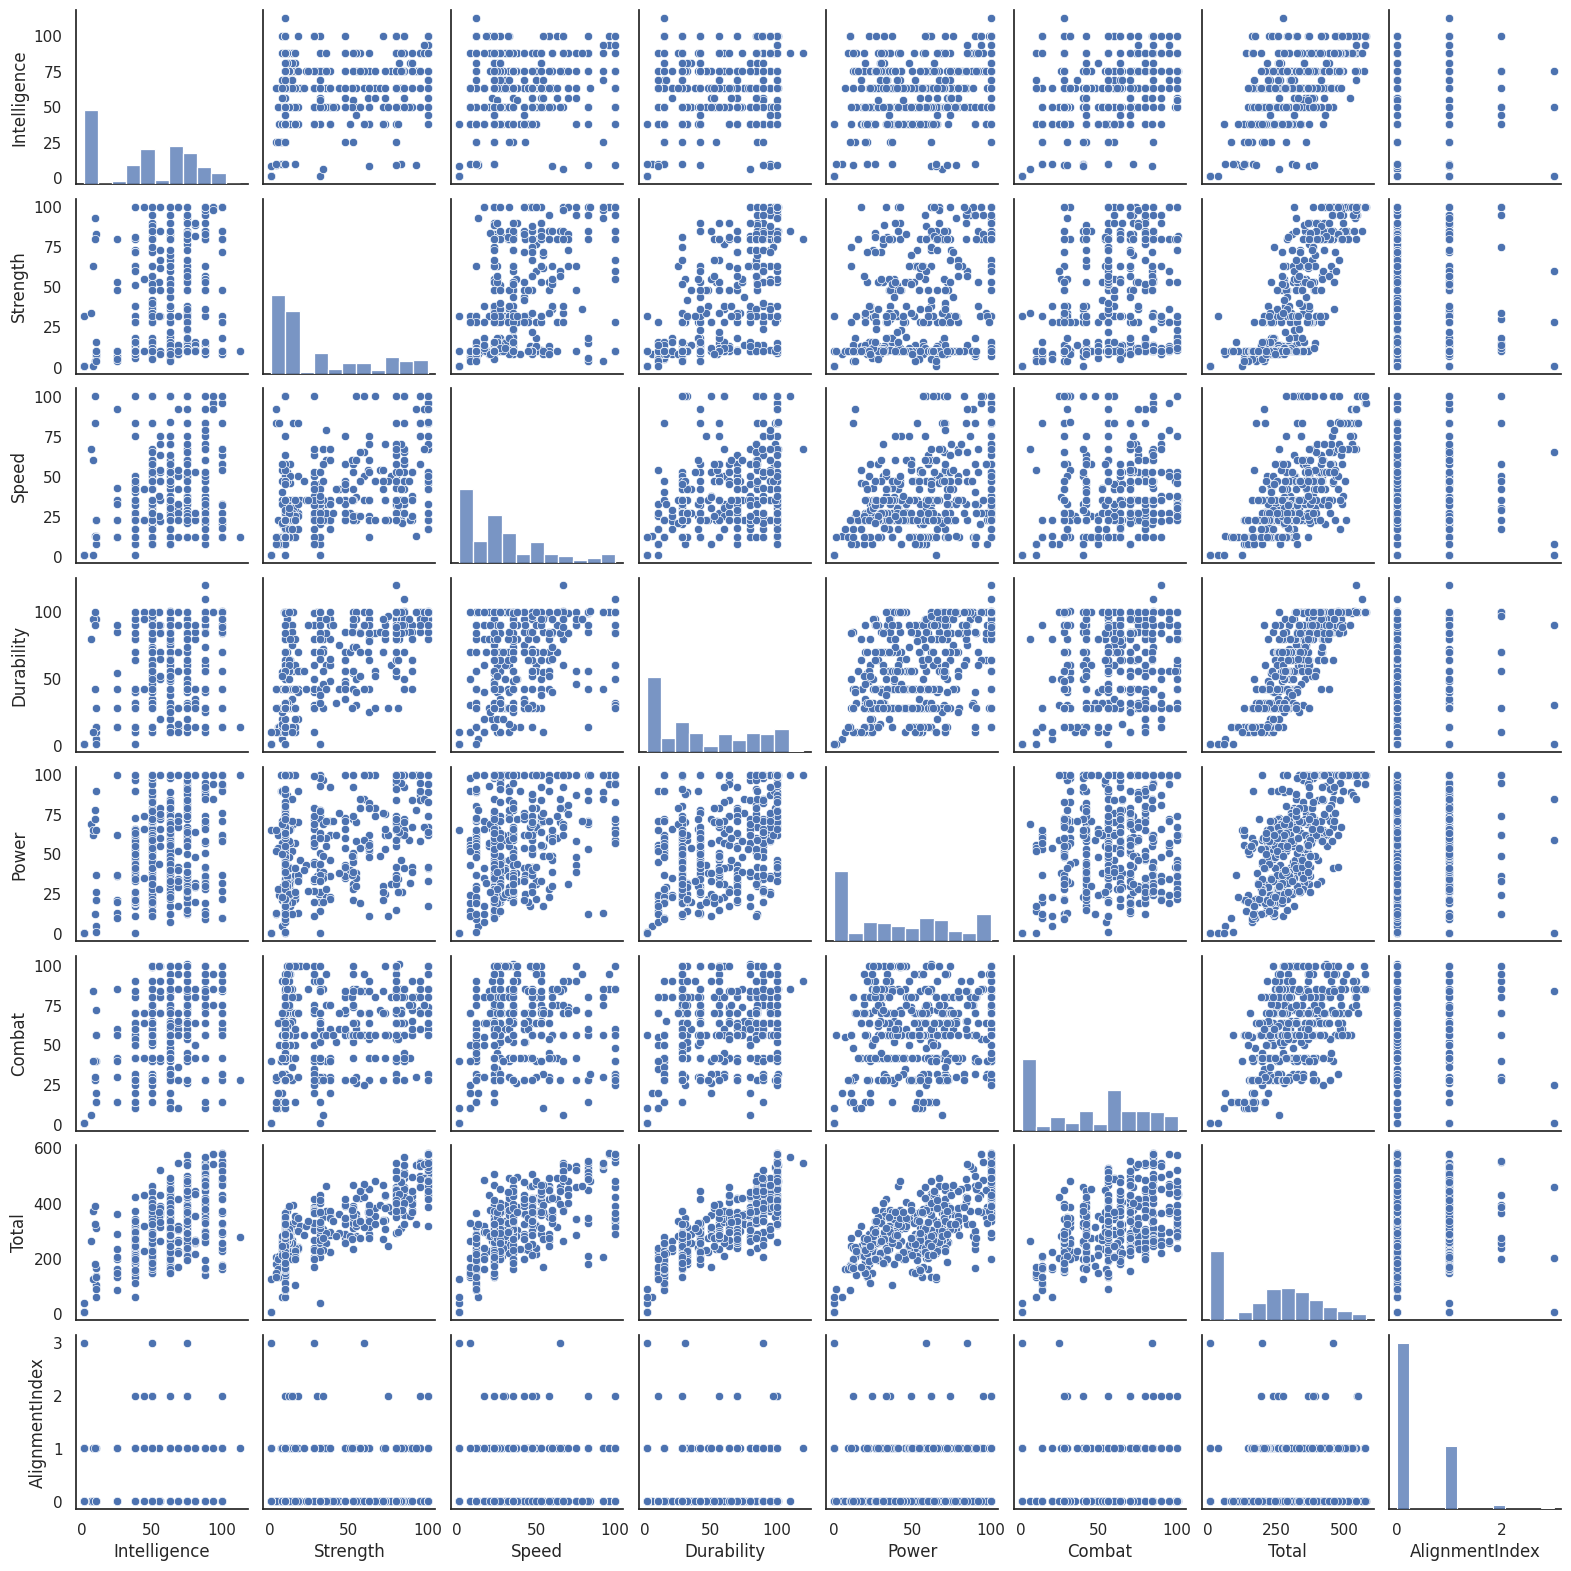

In [58]:
import seaborn as sns

sns.set(style="white")
pd_df = indexed.toPandas()
cols = pd_df.columns
sns.pairplot(pd_df[cols], height=2.0)

<AxesSubplot: xlabel='Intelligence', ylabel='Count'>

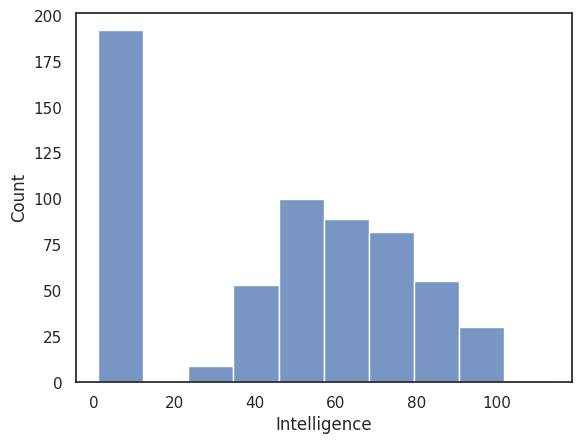

In [59]:
import seaborn as sns

sns.histplot(pd_df.get("Intelligence"), bins=10)

<AxesSubplot: xlabel='Strength', ylabel='Count'>

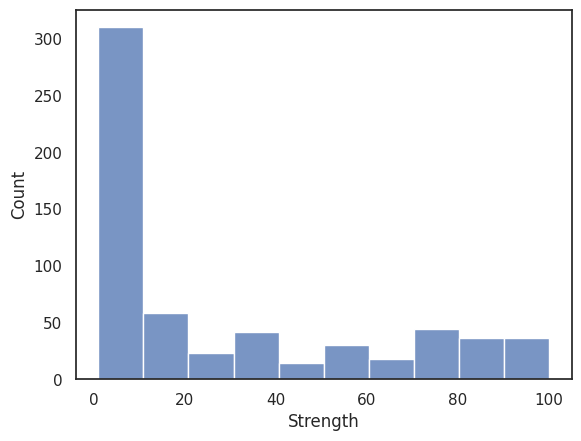

In [62]:
sns.histplot(pd_df.get("Strength"), bins=10)

<AxesSubplot: xlabel='Speed', ylabel='Count'>

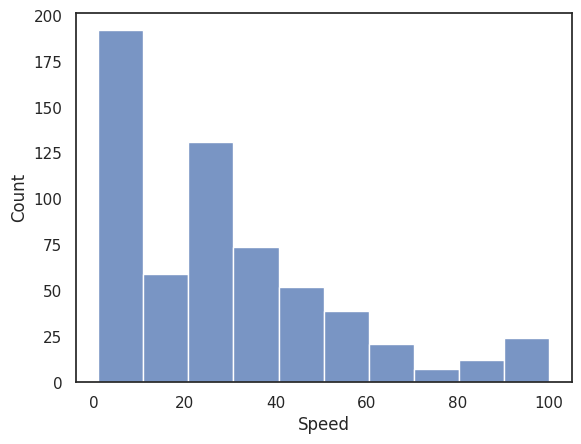

In [63]:
sns.histplot(pd_df.get("Speed"), bins=10)

<AxesSubplot: xlabel='Durability', ylabel='Count'>

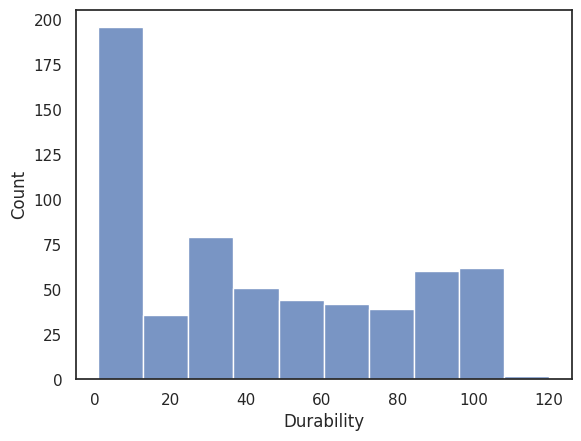

In [64]:
sns.histplot(pd_df.get("Durability"), bins=10)

<AxesSubplot: xlabel='Power', ylabel='Count'>

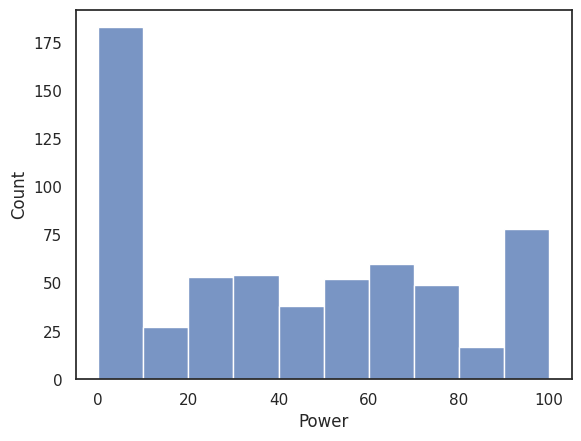

In [65]:
sns.histplot(pd_df.get("Power"), bins=10)

<AxesSubplot: xlabel='Combat', ylabel='Count'>

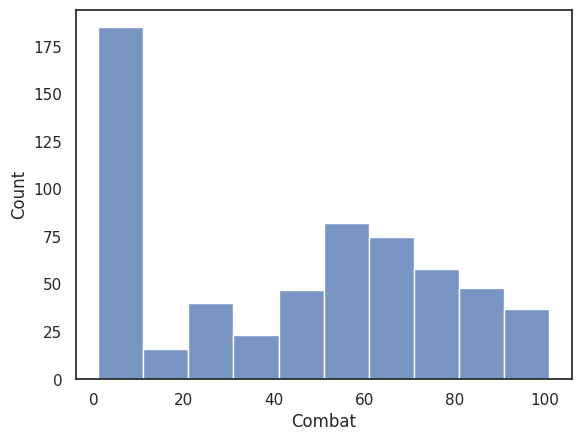

In [66]:
sns.histplot(pd_df.get("Combat"), bins=10)

<AxesSubplot: xlabel='AlignmentIndex', ylabel='Count'>

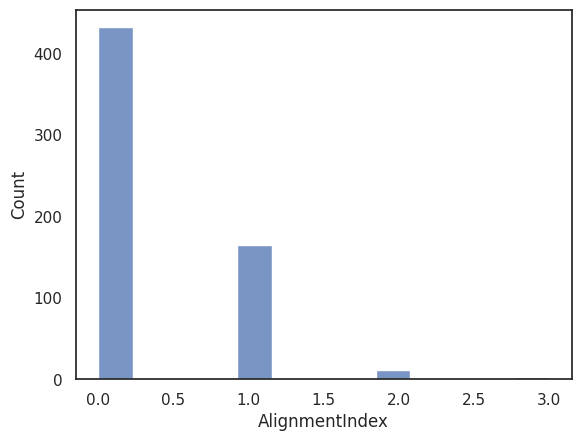

In [67]:
sns.histplot(pd_df.get("AlignmentIndex"))

In [85]:
from pyspark.ml.feature import VectorAssembler
required_features = ['Intelligence',
                    'Strength',
                    'Speed',
                    'Durability',
                    'Power',
                    'AlignmentIndex'
                   ]
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(indexed)
transformed_data.show()

+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+
|             Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|            features|
+-----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+
|          3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|           0.0|[50.0,31.0,43.0,3...|
|           A-Bomb|     good|          38|     100|   17|        80|   17|    64|  316|           0.0|[38.0,100.0,17.0,...|
|       Abe Sapien|     good|          88|      14|   35|        42|   35|    85|  299|           0.0|[88.0,14.0,35.0,4...|
|         Abin Sur|     good|          50|      90|   53|        64|   84|    65|  406|           0.0|[50.0,90.0,53.0,6...|
|      Abomination|      bad|          63|      80|   53|        90|   55|    95|  436|           1.0|[63.0,80.0,53.0,9...|
|       

In [86]:
from pyspark.ml.regression import RandomForestRegressor

(training_data, test_data) = transformed_data.randomSplit([0.6,0.4])
rf = RandomForestRegressor(labelCol='Combat', featuresCol="features")

model = rf.fit(training_data)
predictions = model.transform(test_data)
# Select example rows to display.
predictions.show()

+----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+------------------+
|            Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|            features|        prediction|
+----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+------------------+
|         3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|           0.0|[50.0,31.0,43.0,3...| 61.19195881994094|
|          A-Bomb|     good|          38|     100|   17|        80|   17|    64|  316|           0.0|[38.0,100.0,17.0,...| 51.43926020817556|
|        Abin Sur|     good|          50|      90|   53|        64|   84|    65|  406|           0.0|[50.0,90.0,53.0,6...| 58.65436973402973|
|         Abraxas|      bad|          88|     100|   83|        99|  100|    56|  526|           1.0|[88.0,100.0,83.0,...| 70.14369395315984|
|    A

In [74]:
model.save("../data/models/marvel_combat_1")

In [82]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

required_features = ['Intelligence',
                    'Speed',
                    'Durability',
                    'Power',
                   ]
assembler = VectorAssembler(inputCols=required_features, outputCol='features')
transformed_data = assembler.transform(indexed)
(training_data, test_data) = transformed_data.randomSplit([0.6,0.4])
rf = RandomForestRegressor(labelCol='Combat', featuresCol="features")

model_enhanced = rf.fit(training_data)
predictions_enhanced = model_enhanced.transform(test_data)
predictions_enhanced.show()

+----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+------------------+
|            Name|Alignment|Intelligence|Strength|Speed|Durability|Power|Combat|Total|AlignmentIndex|            features|        prediction|
+----------------+---------+------------+--------+-----+----------+-----+------+-----+--------------+--------------------+------------------+
|         3-D Man|     good|          50|      31|   43|        32|   25|    52|  233|           0.0|[50.0,43.0,32.0,2...|62.299991625802704|
|         Abraxas|      bad|          88|     100|   83|        99|  100|    56|  526|           1.0|[88.0,83.0,99.0,1...| 74.32726542232828|
|      Agent Zero|     good|          75|      28|   38|        80|   72|    95|  388|           0.0|[75.0,38.0,80.0,7...| 66.78505787334902|
|Allan Quatermain|     good|           1|       1|    1|         1|    0|     1|    5|           0.0|   [1.0,1.0,1.0,0.0]|               1.0|
|     

In [83]:
model_enhanced.save("../data/models/marvel_combat_2")

In [87]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="Combat", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(
    labelCol="Combat", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)

print("Adjusted R Square on test data = %g" % r2)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# treeModel = model.stages[1]
# summary only
print(model)

Adjusted R Square on test data = 0.701605
Root Mean Squared Error (RMSE) on test data = 17.8026
RandomForestRegressionModel: uid=RandomForestRegressor_08d0dd26c7a5, numTrees=20, numFeatures=6


In [88]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="Combat", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
r2_evaluator = RegressionEvaluator(
    labelCol="Combat", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions_enhanced)

print("Adjusted R Square on test data = %g" % r2)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

# treeModel = model.stages[1]
# summary only
print(model_enhanced)

Adjusted R Square on test data = 0.729725
Root Mean Squared Error (RMSE) on test data = 17.8026
RandomForestRegressionModel: uid=RandomForestRegressor_ca74245635a8, numTrees=20, numFeatures=4
